# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 04.02.2023

Мягкий дедлайн: 23:59MSK 20.02.2023

Жесткий дедлайн: 23:59MSK 26.02.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [1]:
# в чате увидел, что это ускоряет работу SVM, так что попробуем
%pip install scikit-learn-intelex
import sklearnex
sklearnex.patch_sklearn()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [2]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

### __Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

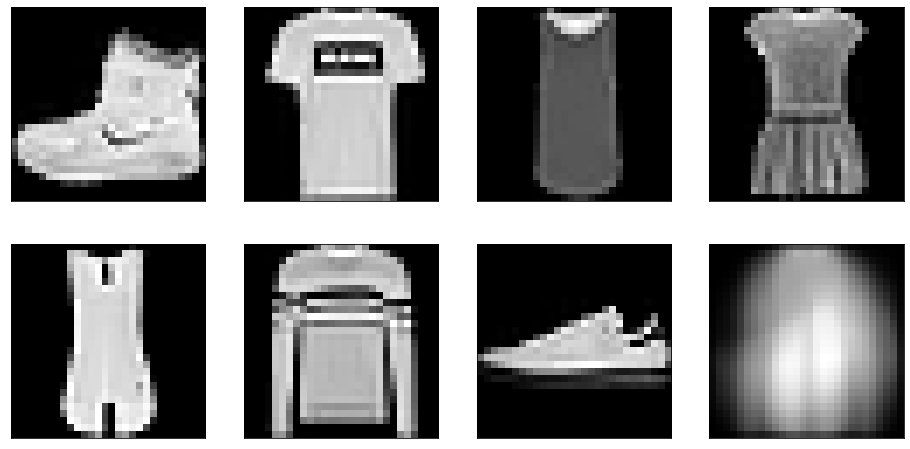

In [ ]:
mean_fashion = x_train_pics.mean(axis=0)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples - 1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x_train_pics[i, :].reshape(x_train_pics.shape[1:]), interpolation='none', cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
plt.subplot(rows, cols, n_samples)
plt.imshow(mean_fashion.reshape(x_train_pics.shape[1:]), interpolation='none', cmap='gray')
plt.xticks(())
_ = plt.yticks(())

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler, Normalizer

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.normalize = Normalizer()
        self.scale = StandardScaler()
        self.model_pca = None
        self.sigma = None
        self.weights = None
        self.bias = None

    def transform(self, X):
        X = self.scale.transform(X)
        X = self.normalize.transform(X)

        # PCA
        if self.use_PCA:
          X = self.model_pca.transform(X)

        # generating random features
        rff = np.cos(X @ self.weights + self.bias)
        return rff
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X = X.copy().astype(np.float64)
        X = self.scale.fit_transform(X)
        X = self.normalize.fit_transform(X)

        # PCA
        if self.use_PCA:
          self.model_pca = PCA(n_components=self.new_dim)
          X = self.model_pca.fit_transform(X)
        
        # calculating sigma
        indices = np.random.choice(np.arange(X.shape[0]), (2, min(int(1e6), X.shape[0])))
        indices = indices[:, indices[1] != indices[0]]
        self.sigma = np.median(np.sum((X[indices[0]] - X[indices[1]])**2, axis=1))

        # generating random features
        self.weights = np.random.normal(0, 1 / self.sigma, (X.shape[1], self.n_features))
        self.bias = np.random.uniform(-np.pi, np.pi, (1, self.n_features))
        rff = np.cos(X @ self.weights + self.bias)

        if self.classifier == 'logreg':
          self.classifier = LogisticRegression(max_iter=1e4)
        elif self.classifier == 'svm':
          self.classifier = LinearSVC(max_iter=1e4)
        else:
          raise Exception('Supports only logreg or svm classifier')
        
        self.classifier.fit(rff, y)

        """
        plt.figure(figsize=(16, 8))
        rows, cols = 2, 4
        n_samples = rows * cols
        for i in range(n_samples):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(X_restored[i].reshape((28, 28)), interpolation='none', cmap='gray')
            plt.xticks(())
            plt.yticks(())
        """
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = X.copy().astype(np.float64)
        rff = self.transform(X)
        return self.classifier.predict_proba(rff)

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = X.copy().astype(np.float64)
        rff = self.transform(X)
        return self.classifier.predict(rff)

### __Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

In [10]:
np.random.seed(42)
trunc_idx = np.random.choice(np.arange(x_train.shape[0]), 10000, replace=False)

Для чистоты эксперимента буду ставить везде max_iter=10000

#### LogReg на случайные признаки

In [ ]:
%%time
RFF = RFFPipeline()
RFF.fit(x_train[trunc_idx], y_train[trunc_idx])

CPU times: user 4min 55s, sys: 3min 35s, total: 8min 31s
Wall time: 5min 54s


RFFPipeline(classifier=LogisticRegression(max_iter=10000.0))

In [ ]:
%%time
y_pred = RFF.predict(x_test)
print('LogReg on RFF accuracy:', accuracy_score(y_test, y_pred))

LogReg on RFF accuracy: 0.864
CPU times: user 648 ms, sys: 400 ms, total: 1.05 s
Wall time: 1.03 s


#### Linear SVM на исходных признаках

In [ ]:
%%time
clf = LinearSVC(max_iter=10000)
clf.fit(x_train[trunc_idx], y_train[trunc_idx])

CPU times: user 4min 18s, sys: 315 ms, total: 4min 18s
Wall time: 4min 28s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=10000)

In [ ]:
%%time
y_pred = clf.predict(x_test)
print('Linear SVM on original features accuracy:', accuracy_score(y_test, y_pred))

Linear SVM on original features accuracy: 0.7658
CPU times: user 53.4 ms, sys: 24.1 ms, total: 77.5 ms
Wall time: 79.5 ms


#### RBF Kernel SVM на исходных признаках

In [ ]:
%%time
clf = SVC(kernel='rbf')
clf.fit(x_train[trunc_idx], y_train[trunc_idx])

CPU times: user 3min 22s, sys: 8.13 s, total: 3min 30s
Wall time: 3min 33s


SVC()

In [ ]:
%%time
y_pred = clf.predict(x_test)
print('RBF Kernel SVM on original features accuracy:', accuracy_score(y_test, y_pred))

Kernel SVM on original features accuracy: 0.8827
CPU times: user 30.2 s, sys: 237 ms, total: 30.4 s
Wall time: 30.3 s


#### Polynomial Kernel SVM на исходных признаках

In [ ]:
%%time
clf = SVC(kernel='poly')
clf.fit(x_train[trunc_idx], y_train[trunc_idx])

CPU times: user 16.3 s, sys: 509 ms, total: 16.8 s
Wall time: 16.7 s


SVC(kernel='poly')

In [ ]:
%%time
y_pred = clf.predict(x_test)
print('Polynomial Kernel SVM on original features accuracy:', accuracy_score(y_test, y_pred))

Polynomial Kernel SVM on original features accuracy: 0.8197
CPU times: user 10.6 s, sys: 106 ms, total: 10.7 s
Wall time: 10.7 s


#### CatBoost + PCA

In [ ]:
!pip install catboost
!pip install ipywidgets

!jupyter nbextension enable --py widgetsnbextension

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from catboost import CatBoostClassifier

def pca_catboost_gridsearch(X, y):
        X = X.copy().astype(np.float64)
        X = StandardScaler().fit_transform(X)
        X = Normalizer().fit_transform(X)
        model_pca = PCA(n_components=50)
        X = model_pca.fit_transform(X)
        model = CatBoostClassifier(loss_function='MultiClass')
        grid = {
            'learning_rate': [2e-3, 0.03, 0.1],
            'iterations': np.linspace(10, 100, 10)}
        grid_search_result = model.grid_search(grid,
                                       X=X,
                                       y=y,
                                       plot=True,
                                       verbose=False)
        return grid_search_result


In [ ]:
catboost_best_params = pca_catboost_gridsearch(x_train, y_train)

In [ ]:
catboost_best_params['params']

{'learning_rate': 0.1, 'iterations': 100.0}

In [ ]:
def get_catboost_model(X, y):
    scaler = StandardScaler()
    normalizer = Normalizer()

    X = X.copy().astype(np.float64)
    X = scaler.fit_transform(X)
    X = normalizer.fit_transform(X)

    model_pca = PCA(n_components=50)
    X = model_pca.fit_transform(X)

    model = CatBoostClassifier(loss_function='MultiClass', learning_rate=catboost_best_params['params']['learning_rate'], iterations=catboost_best_params['params']['iterations'])
    model.fit(X, y)
    return model, model_pca, scaler, normalizer

def catpca_predict(X, y, scaler, normalizer, model, pca_model):
    X = X.copy().astype(np.float64)
    X = scaler.transform(X)
    X = normalizer.transform(X)
    y_pred = model.predict(pca_model.transform(X))
    print('CatBoost + PCA accuracy:', accuracy_score(y, y_pred))

In [ ]:
%%time
catboost_model, pca_model, scaler, normalizer = get_catboost_model(x_train, y_train)

0:	learn: 1.9566750	total: 749ms	remaining: 1m 14s
1:	learn: 1.7593715	total: 1.81s	remaining: 1m 28s
2:	learn: 1.5981160	total: 3.16s	remaining: 1m 42s
3:	learn: 1.4757417	total: 4.5s	remaining: 1m 47s
4:	learn: 1.3775933	total: 6.2s	remaining: 1m 57s
5:	learn: 1.3011625	total: 7.24s	remaining: 1m 53s
6:	learn: 1.2309366	total: 8.13s	remaining: 1m 48s
7:	learn: 1.1669374	total: 8.9s	remaining: 1m 42s
8:	learn: 1.1147061	total: 9.69s	remaining: 1m 38s
9:	learn: 1.0687089	total: 10.7s	remaining: 1m 36s
10:	learn: 1.0320390	total: 11.4s	remaining: 1m 32s
11:	learn: 0.9950008	total: 12.2s	remaining: 1m 29s
12:	learn: 0.9598705	total: 12.7s	remaining: 1m 25s
13:	learn: 0.9324897	total: 13.2s	remaining: 1m 21s
14:	learn: 0.9050648	total: 13.7s	remaining: 1m 17s
15:	learn: 0.8795382	total: 14.2s	remaining: 1m 14s
16:	learn: 0.8582865	total: 14.6s	remaining: 1m 11s
17:	learn: 0.8364072	total: 15.2s	remaining: 1m 9s
18:	learn: 0.8177358	total: 16.1s	remaining: 1m 8s
19:	learn: 0.7988648	total:

In [ ]:
%%time
catpca_predict(x_test, y_test, scaler, normalizer, catboost_model, pca_model)

CatBoost + PCA accuracy: 0.8295
CPU times: user 286 ms, sys: 61.5 ms, total: 347 ms
Wall time: 341 ms


|                           | **Train time** | **Inference time** | **Accuracy** |
|---------------------------|----------------|--------------------|--------------|
| **LogReg + RFF + PCA**    | 4min 55s       | 648ms              | 86.4%        |
| **Linear SVM**            | 4min 18s       | 53.4ms             | 76.58%       |
| **RBF kernel SVM**        | 3min 22s       | 30.2s              | 88.27%       |
| **Polynomial kernel SVM** | 16.3s          | 10.6s              | 81.97%       |
| **CatBoost + PCA**        | 1min 32s       | 286ms              | 82.95%       |
| **LogReg + RFF**          | 4min 27s       | 1.35s              | 84.19%       |
| **SVM + RFF + PCA**       | 7min 17s       | 687ms              | 85.77%       |
| **SVM + RFF**             | 5min 29s       | 1.37s              | 82.55%       |

Видим, что методы использующие случайные признаки медленнее по времени инференса, но при этом дают более высокий accuracy. Также заметим, что обычные ядровые SVM (RBF, Polynomial) работают очень доолго (10 и 30 секунд) для определения класса лишь одного объекта, в то время как логистическая регрессия и линейный svm на случайных признаках занимает около 660ms с PCA и 1.35 без него. При этом время обучения SVM больше чем у LogReg и качество ниже. По итогу исполльзование RFF немного замедляет инференс по сравнению с линейным моделями, но обгоняет как по скорости предикта, так и по accuracy ядровые методы (кроме RBF Kernel, который дал 88.27% точности). На скорость обучения RFF в моих экспериментах особо не повлиял, но polynomial kernel обогнал все остальные методы и обучиллся всего за 16 секунд, дав при этом не очень высокое качество 82%. CatBoost требует многоо времени на подборо параметров, но сама скорость обучения оказалась одной из самых высоких, как и скорость инференса, качество 83%, что хуже чем у большинства других методов.

### __Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

Попробуем не использовать PCA

In [ ]:
%%time
RFF = RFFPipeline(use_PCA=False)
RFF.fit(x_train[trunc_idx], y_train[trunc_idx])

CPU times: user 4min 27s, sys: 3min 22s, total: 7min 50s
Wall time: 4min 30s


RFFPipeline(classifier=LogisticRegression(max_iter=10000.0), use_PCA=False)

In [ ]:
%%time
y_pred = RFF.predict(x_test)
print('RFF + no PCA accuracy:', accuracy_score(y_test, y_pred))

RFF + no PCA accuracy: 0.8419
CPU times: user 1.35 s, sys: 288 ms, total: 1.64 s
Wall time: 1.02 s


In [ ]:
%%time
RFF = RFFPipeline(use_PCA=False, classifier='svm')
RFF.fit(x_train[trunc_idx], y_train[trunc_idx])

CPU times: user 5min 29s, sys: 389 ms, total: 5min 29s
Wall time: 5min 29s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RFFPipeline(classifier=LinearSVC(max_iter=10000.0), use_PCA=False)

In [ ]:
%%time
y_pred = RFF.predict(x_test)
print('RFF + no PCA accuracy:', accuracy_score(y_test, y_pred))

RFF + no PCA accuracy: 0.8255
CPU times: user 1.37 s, sys: 222 ms, total: 1.59 s
Wall time: 983 ms


In [ ]:
acc_by_n_features = []

for n_features in (50, 150, 500, 1100, 1500):
  RFF = RFFPipeline(n_features=n_features)
  RFF.fit(x_train[trunc_idx], y_train[trunc_idx])
  y_pred = RFF.predict(x_test)
  acc_by_n_features.append(accuracy_score(y_test, y_pred))
  print(f'RFF + PCA, n_features={n_features} accuracy:', acc_by_n_features[-1])

RFF + PCA, n_features=50 accuracy: 0.8085
RFF + PCA, n_features=150 accuracy: 0.8426
RFF + PCA, n_features=500 accuracy: 0.8595
RFF + PCA, n_features=1100 accuracy: 0.8632
RFF + PCA, n_features=1500 accuracy: 0.8633


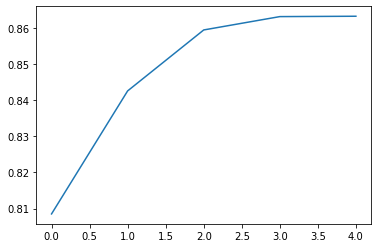

In [ ]:
from matplotlib.pyplot import plot

plot(acc_by_n_features)

In [11]:
%%time
RFF = RFFPipeline(classifier='svm')
RFF.fit(x_train[trunc_idx], y_train[trunc_idx])

CPU times: user 7min 17s, sys: 960 ms, total: 7min 18s
Wall time: 7min 20s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RFFPipeline(classifier=LinearSVC(max_iter=10000.0))

In [12]:
%%time
y_pred = RFF.predict(x_test)
print('RFF + PCA accuracy:', accuracy_score(y_test, y_pred))

RFF + PCA accuracy: 0.8577
CPU times: user 687 ms, sys: 203 ms, total: 890 ms
Wall time: 846 ms


### Результаты

|                           | **Train time** | **Inference time** | **Accuracy** |
|---------------------------|----------------|--------------------|--------------|
| **LogReg + RFF + PCA**    | 4min 55s       | 648ms              | 86.4%        |
| **Linear SVM**            | 4min 18s       | 53.4ms             | 76.58%       |
| **RBF kernel SVM**        | 3min 22s       | 30.2s              | 88.27%       |
| **Polynomial kernel SVM** | 16.3s          | 10.6s              | 81.97%       |
| **CatBoost + PCA**        | 1min 32s       | 286ms              | 82.95%       |
| **LogReg + RFF**          | 4min 27s       | 1.35s              | 84.19%       |
| **SVM + RFF + PCA**       | 7min 17s       | 687ms              | 85.77%       |
| **SVM + RFF**             | 5min 29s       | 1.37s              | 82.55%       |

1. Уменьшение размерности с помощью PCA ускоряет скорость инференса, но немного замедляет скорость обучения (очевидно из-за необходимости переводить признаки в другой базис). PCA дает улучшение accuracy на ~2% как для svm, так и для logreg.

2. Чем больше случайных признаков мы берем, тем больше информации первоначальной выборки они содержат, поэтому в какой то момент качество перестает расти, как видно на графике.

3. Логистическая регрессия обоучается быстрее, у нее практически такая же скорость инференса, но она дает более высокую точность 86.4% против 85.77% (с использоованием RFF и PCA), поэтому лучше использовать ее.